In [1]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [2]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

# EnsembleTransformer definition

In [3]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0], :].unsqueeze(1).expand(-1, x.shape[1], -1)
        return self.dropout(x)
        

# EnsembleTransformer: takes a history of MIDI messages 
# for instruments in an ensemble and generates a distribution for the next message,
# as well as the instrument who should issue the message
class EnsembleTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    def __init__(self, message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size):
        super(EnsembleTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # Indicates which channel is associated with each instrument, as well as
        # the position of messages in time
        self.position_encoding = PositionalEncoding(embed_dim)
        
        # The encoder computes attention over the instrument embeddings
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        encoder_layer = torch.nn.TransformerEncoderLayer(embed_dim, heads, ff_size)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, attention_layers)
        
        # The decoder computes attention over the message history, using the above
        # encoding as memory
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        decoder_layer = torch.nn.TransformerDecoderLayer(embed_dim, heads, ff_size)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, attention_layers)

        # The decoding is passed through a linear layer to get the logits for the next message        
        self.message_logits = torch.nn.Linear(embed_dim, message_dim)
        
        # The decoding becomes a query for attention across the instruments, which is used to
        # predict the next instrument
        self.inst_attention = torch.nn.MultiheadAttention(embed_dim, heads)
    
    # forward: generates a probability distribution for the next MIDI message
    # and the channel that issues the message, given a message history for the instrument ensemble
    # ARGUMENTS
    # history: an LxBx2 tensor, where L is the length of the longest message history in
    # the batch, and B is the batch size. The first index along dimension 2 stores the
    # message number. The second stores the channel number. This should be END-PADDED
    # along dimension 0. All time shifts should be associated with channel -1.
    # mask: an LxB tensor, containing True in any locations where history contains
    # padding
    # instruments: a NxB tensor indicating the instrument number for each channel, where
    # N is the maximum number of channels in the batch. This should be END-PADDED along dimension 0
    # inst_mask: contains False where an instrument exists, True where it doesn't
    # RETURN: two tensors. The first is LxBxD, representing the distribution for the next message at each time
    # step (need to take the softmax to get actual probabilities). The second is LxBxC, representing the
    # distribution for the next channel at each time step (need to take the softmax to get actual probabilities)
    def forward(self, history, mask, instruments, inst_mask):
        L = history.shape[0] # longest length
        B = history.shape[1] # batch size
        N = instruments.shape[0]
        assert(mask.shape == (L, B))
        assert(inst_mask.shape == instruments.shape)
        
        # NxBxD
        inst_embed = self.position_encoding(torch.tanh(self.i_embedding(instruments)))
        
        inst_encoding = self.encoder(inst_embed, src_key_padding_mask=inst_mask.transpose(0, 1))
        
        # Which messages are time shifts?
        time_shift_mask = history[:, :, 1] < 0
        
        # LxBxD, instrument embedding associated with each message
        inst_sel = history[:, :, 1].unsqueeze(2).expand(-1, -1, self.embed_dim).clone()
        inst_sel[time_shift_mask] = 0
        
        inst_tags = torch.gather(inst_embed, 0, inst_sel)
        inst_tags[time_shift_mask] = 0
        
        # LxBxD
        decoder_inputs = self.position_encoding(self.embedding(history[:, :, 0])) + inst_tags
        
        tgt_mask = torch.triu(torch.ones((L, L), dtype=torch.bool))
        tgt_mask.fill_diagonal_(False)
        tgt_key_padding_mask = mask.transpose(0, 1)
        
        decoding = self.decoder(decoder_inputs, inst_embed, \
                                tgt_mask=tgt_mask, \
                                tgt_key_padding_mask=tgt_key_padding_mask,
                                memory_key_padding_mask=inst_mask.transpose(0, 1))
        
        # LxBxD
        message_dist = self.message_logits(decoding)
        
        # channel_dist (BxLxN) contains the attention weights for each instrument.
        # We have L queries (the elements of decoding). Our keys and values
        # are the instrument embeddings
        att_out, channel_dist = self.inst_attention(self.position_encoding(decoding), \
                                                    inst_embed, inst_embed,
                                                    key_padding_mask = inst_mask.transpose(0, 1))
        
        return message_dist, channel_dist.transpose(0, 1)

# Tests for EnsembleTransformer
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single song

In [16]:
embed_dim = 512
heads = 4
attention_layers = 6
ff_size = 512

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [35]:
model.load_state_dict(torch.load('unified_transformer.pth'))

<All keys matched successfully>

In [ ]:
recording = np.load('train_unified/recording0.npy', allow_pickle=True)
instruments_np = np.load('train_unified/instruments0.npy', allow_pickle=True)

nsamples = 500

history = torch.tensor(recording[:nsamples], dtype=torch.long).view(-1, 1, 2)
mask = torch.zeros((history.shape[0], history.shape[1]), dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(i) for i in instruments_np], dtype=torch.long).view(-1, 1)
inst_mask = torch.zeros(instruments.shape, dtype=torch.bool)

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
message_loss = torch.nn.CrossEntropyLoss()
channel_loss = torch.nn.NLLLoss(ignore_index=-1)
epochs = 500
train_losses = np.zeros(epochs)

target_messages = history[1:, :, 0].flatten()
target_channels = history[1:, :, 1].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    message_logits, channel_dist = model(history[:-1], mask[:-1], instruments, inst_mask)
    channel_log_dist = torch.log(channel_dist + 1e-8)
    
    loss = message_loss(message_logits.view(-1, message_dim), target_messages) + \
           channel_loss(channel_log_dist.view(-1, num_channels), target_channels)
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

In [21]:
torch.save(model.state_dict(), 'unified_transformer.pth')

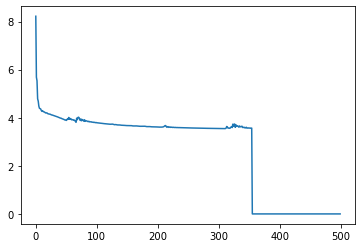

In [43]:
plt.plot(train_losses)

In [ ]:
# Sample from model
gen_history = history[0].unsqueeze(0)
gen_mask = torch.zeros((1, 1), dtype=torch.bool)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

# Move forward in time
wrong_cnt = 0
for t in range(0, history.shape[0] - 1):
    message_logits, channel_dist = model(gen_history, gen_mask, instruments, inst_mask)
    print(channel_dist[-1])
    
    #message = torch.multinomial(torch.softmax(message_logits[-1].flatten(), dim=0), 1)
    #channel = torch.multinomial(channel_dist[-1].flatten(), 1)
    
    message = torch.argmax(message_logits[-1].flatten())
    channel = torch.argmax(channel_dist[-1].flatten())
    
    append = torch.tensor([message, channel]).view(1, 1, 2)
    
    gen_history = torch.cat((gen_history, append), dim=0)
    
    if gen_history[-1, 0, 0] != history[t + 1, 0, 0]:
        print('Wrong message at time %d!' %(t))
        wrong_cnt += 1
        
    if gen_history[-1, 0, 1] != history[t + 1, 0, 1]:
        print('Wrong instrument at time %d!' %(t))
        wrong_cnt += 1
    
    gen_mask = torch.cat((gen_mask, torch.zeros((1, 1), dtype=torch.bool)), dim=0)

print(wrong_cnt)

In [44]:
np.save('test_history.npy', gen_history.squeeze(1).detach().numpy())
np.save('test_instruments.npy', [instrument_numbers[i] for i in instruments[:-1, 0]])

# Custom dataset class

In [4]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    # chunk_size: we'll chunk the data into chunks of this size (or less)
    def __init__(self, root_dir, chunk_size, transform=None):
        files = os.listdir(root_dir)
        recording_files = []
        instrument_files = []
        for file in files:
            if 'recording' in file:
                recording_files.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(recording_files) == len(instrument_files))
        recording_files.sort()
        instrument_files.sort()
        self.transform = transform
        
        self.recordings = []
        self.instruments = []
        for f in range(len(recording_files)):
            recording = np.load(recording_files[f], allow_pickle=True)
            inst = np.load(instrument_files[f], allow_pickle=True)
            for chunk_start in range(0, recording.shape[0], chunk_size):
                chunk_end = min(chunk_start + chunk_size, recording.shape[0])
                self.recordings.append(recording[chunk_start:chunk_end])
                self.instruments.append(inst)

    # __len__
    # RETURN: number of chunks in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which chunk to get
    # RETURN: an instance with keys 'instruments', 'history'
    # instance['history'] is an Lx2 numpy array containing messages and associated channels
    # instance['instruments'] a numpy array of instrument numbers
    def __getitem__(self, idx):
        instance = {'history': self.recordings[idx], \
                    'instruments': self.instruments[idx]}
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [5]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch.
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', and 'mask'
# sample['history']: an LxBx2 tensor containing messages and their associated channels
# sample['instruments']: a CxB tensor containing instrument numbers for each channel
# sample['mask']: an LxB tensor containing False where a message is
# valid, and True where it isn't (accounts for variable length sequences
# and zero padding)
# sample['inst_mask']: an NxB tensor containing False where an instrument exists and True
# otherwise
def collate_fn(batch):
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest number of instruments
    max_inst = max([instance['instruments'].shape[0] for instance in batch])
    longest_len = max([instance['history'].shape[0] for instance in batch])

    sample = {'history': torch.zeros((longest_len, batch_size, 2), dtype=torch.long), \
              'instruments': torch.zeros((max_inst, batch_size), dtype=torch.long), \
              'mask': torch.ones((longest_len, batch_size), dtype=torch.bool), \
              'inst_mask': torch.ones((max_inst, batch_size), dtype=torch.bool)}

    for b, instance in enumerate(batch):
        instrument_idx = [instrument_numbers.index(i) for i in instance['instruments']]
        
        sample['instruments'][:len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        
        sample['inst_mask'][:len(instrument_idx), b] = False
        
        seq_length = instance['history'].shape[0]
        sample['history'][:seq_length, b] = torch.tensor(instance['history'], dtype=torch.long)
        sample['mask'][:seq_length, b] = False
            
    return sample

# Train the model

In [10]:
# compute_loss: computes the loss for the model over the batch
# ARGUMENTS
# model: EnsembleTransformer model
# message_loss_fn: torch.nn.CrossEntropyLoss object
# channel_loss_fn: torch.nn.NLLLoss object
# batch: see collate_fn definition
# RETURN: a scalar loss tensor
def compute_loss(model, message_loss_fn, channel_loss_fn, batch):  
    max_seq_length = batch['history'].shape[0]

    message_logits, channel_dist = model(batch['history'][:-1], batch['mask'][:-1], batch['instruments'], batch['inst_mask'])
    log_channel_dist = torch.log(channel_dist + 1e-10)

    target_mask = torch.logical_not(batch['mask'][1:])

    message_loss = message_loss_fn(message_logits[target_mask], batch['history'][1:, :, 0][target_mask])
    channel_loss = channel_loss_fn(log_channel_dist[target_mask], batch['history'][1:, :, 1][target_mask])

    return message_loss + channel_loss

In [11]:
embed_dim = 512
heads = 4
attention_layers = 6
ff_size = 512

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [12]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 10
learning_rate = 0.001
chunk_size = 500

train_dataset = MIDIDataset('train_unified', chunk_size)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataset = MIDIDataset('test_unified', chunk_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

message_loss_fn = torch.nn.CrossEntropyLoss()
channel_loss_fn = torch.nn.NLLLoss(ignore_index=-1)
epochs = 20
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    model.train()
    for b, batch in enumerate(train_dataloader):
        print('Starting iteration %d' %(b))
        loss = compute_loss(model, message_loss_fn, channel_loss_fn, batch)
        optimizer.zero_grad()
        loss.backward()
        print(loss.data)
        for p in model.parameters():
            if p.grad is not None:
                print(p.grad.norm())
        optimizer.step()
        
    torch.save(model.state_dict(), 'unified_transformer_models/epoch' + str(epoch) + '.pth')

    print('Computing test loss')
    model.eval()
    for batch in test_dataloader:
        loss = compute_loss(model, message_loss_fn, channel_loss_fn, batch)
        test_losses[epoch] += loss.data
        
    print('Computing train loss')
    for batch in train_dataloader:
        loss = compute_loss(model, message_loss_fn, channel_loss_fn, batch)
        train_losses[epoch] += loss.data
    
    train_losses[epoch] /= len(train_dataloader)
    test_losses[epoch] /= len(test_dataloader)
    print('Train Loss: %f, Test Loss: %f' %(train_losses[epoch], test_losses[epoch]))

In [ ]:
plt.plot(train_losses)

# Sample from the model

In [115]:
model.eval() # Disable dropout to make results repeatable

time_steps = 500 # How many time steps do we sample?

# Start with a time shift
gen_history = torch.zeros((1, 1, 2), dtype=torch.long)
gen_history[0, 0, 0] = 387
gen_history[0, 0, 1] = -1

# Violin
instruments = torch.zeros((1, 1), dtype=torch.long)
instruments[0, 0] = 0
inst_mask = torch.zeros((1, 1), dtype=torch.bool)

gen_mask = torch.zeros((1, 1), dtype=torch.bool)

# Move forward in time
for t in range(0, time_steps):
    message_logits, channel_logits = model(gen_history, gen_mask, instruments)
    
    message = torch.multinomial(torch.softmax(message_logits[-1].flatten(), dim=0), 1)
    channel = torch.multinomial(channel_logits[-1].flatten(), 1)
    
    append = torch.tensor([message, channel]).view(1, 1, 2)
    
    gen_history = torch.cat((gen_history, append), dim=0)
    
    gen_mask = torch.cat((gen_mask, torch.zeros((1, 1), dtype=torch.bool)), dim=0)

print(wrong_cnt)

In [116]:
np.save('gen_history.npy', gen_history.squeeze(1).detach().numpy())
np.save('gen_instruments.npy', [instrument_numbers[i] for i in instruments[:, 0]])